## SVM -- 支持向量机

Support Vector Machine

支持向量就是离超平面最近的那些点

### 优缺点

- 优点：泛化错误率低，计算开销不大，结果易解释。

- 缺点：对参数调节和核函数的选择敏感，原始分类器不加修改只能适用于二分类问题。

### SMO（Sequential Minimal Optimization）-- 序列最小优化

- 目标：求出一系列alpha和b，通过这些alpha可以确定权重w，从而确定超平面

- 工作原理：每次循环中选择两个alpha进行优化处理。一旦找到一堆合适的alpha，那么就增大其中一个同时减小另一个。

### 简化版SMO

> 首先在数据集上遍历每一个alpha，然后再剩下的alpha集合中随机选择另一个alpha，从而构建alpha对。

#### 简化版SMO 伪码
```
当迭代次数小于最大迭代次数（外循环）：
    对数据集中的每个数据向量（内循环）：
        如果该数据向量可以被优化：
            随机选择另一个数据向量
            同时优化这两个数据向量
            如果两个数据向量都不能被优化，退出内循环
    如果所有数据向量都没被优化，增加迭代次数，继续下一次外循环
```
#### 辅助函数

In [1]:
import random
import numpy as np

In [2]:
# 准备数据：打开文件逐行解析文件，并将样本的属性值和标签值分别存储到list中
def loadDataSet(filename):  
    dataMat = []
    lableMat = []
    fr = open(filename)
    for line in fr:
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        lableMat.append(float(lineArr[2]))
    return dataMat, lableMat

# 构造alpha对
def selectJrand(i, m):
    j = i
    while j==i:
        j = int(random.uniform(0, m))
    return j
        
# 调整大于H或小于L的alpha
def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj


In [3]:
dataMat, labelMat = loadDataSet("testSet.txt")
labelMat[:10]

[-1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0]

#### 画出数据

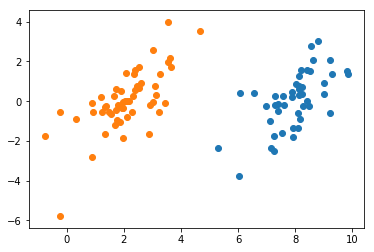

In [53]:
import matplotlib.pyplot as plt
def showDataSet(dataMat, labelMat):
    dataPlus = []
    dataMinus = []
    for i in range(len(dataMat)):
        if labelMat[i] == 1.0:
            dataPlus.append(dataMat[i])
        else:
            dataMinus.append(dataMat[i])
    dataPlusArr = np.array(dataPlus).transpose()
    dataMinusArr = np.array(dataMinus).transpose()
    plt.scatter(dataPlusArr[0], dataPlusArr[1])
    plt.scatter(dataMinusArr[0], dataMinusArr[1])
    plt.show()

    
showDataSet(dataMat, labelMat)

#### 简化版SMO

In [66]:
def smoSimple1(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn)
    labelMat = np.mat(classLabels).transpose()
    b = 0
    m, n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros((m, 1)))
    iter = 0
    while iter < maxIter:
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(np.multiply(alphas, labelMat).T * (dataMatrix * dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i, m)
                fXj = float(np.multiply(alphas, labelMat).T * (dataMatrix * dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                # 由于python中列表是引用传递的，所以这里用copy函数明确的告诉系统要给旧的alpha开辟内存空间
                # 否则的话当修改alphas[i]时， alphaIold也会跟着变化，这样就无法比较新旧alpha的区别了
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L == H:
                    print("L == H")
                    continue
                eta = 2.0 * dataMatrix[i,:] * dataMatrix[j,:].T - dataMatrix[i, :] * dataMatrix[i, :].T \
                - dataMatrix[j, :] * dataMatrix[j, :].T
                if eta >= 0:
                    print("eta >= 0")
                    continue
                alphas[j] -= labelMat[j] * (Ei - Ej ) / eta
                alphas[j] = clipAlpha(alphas[j], H, L)
                if abs(alphas[j] - alphaJold) < 0.00001:
                    print("j not moving enough")
                    continue
                alphas[i] += labelMat[j] * labelMat[i] * (alphaJold - alphas[j])
                b1 = b - Ei - labelMat[i] * (alphas[i] - alphaIold) * dataMatrix[i, :] * dataMatrix[i, :].T \
                - labelMat[j] * (alphaJold - alphas[j]) * dataMatrix[i, :] * dataMatrix[j ,:].T
                b2 = b - Ej - labelMat[i] * (alphas[i] - alphaIold) * dataMatrix[i, :] * dataMatrix[j, :].T \
                - labelMat[j] * (alphas[j] - alphaJold) * dataMatrix[j, :] * dataMatrix[j ,:].T
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2) / 2.0
                alphaPairsChanged += 1
                print("iter: %d i: %d , pairs changed: %d" % (iter, i, alphaPairsChanged))
        if alphaPairsChanged == 0:
            iter += 1
        else:
            iter= 0
        print(" iteration number: %d" % iter)
    return float(b), alphas
    

In [74]:
b, alphas = smoSimple1(dataMat, labelMat, 0.6, 0.001, 40)


iter: 0 i: 0 , pairs changed: 1
L == H
L == H
L == H
iter: 0 i: 8 , pairs changed: 2
L == H
j not moving enough
L == H
L == H
iter: 0 i: 17 , pairs changed: 3
L == H
L == H
j not moving enough
L == H
j not moving enough
iter: 0 i: 25 , pairs changed: 4
L == H
iter: 0 i: 31 , pairs changed: 5
j not moving enough
j not moving enough
L == H
L == H
j not moving enough
j not moving enough
j not moving enough
 iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 23 , pairs changed: 1
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
iter: 0 i: 54 , pairs changed: 2
iter: 0 i: 55 , pairs changed: 3
j not moving enough
L == H
j not moving enough
L == H
j not moving enough
j not moving enough
 iteration number: 0
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
iter: 0 i: 20 , pairs changed: 1
j not moving enough
j not moving enough
iter: 0 i: 25 , pairs changed: 2
L == H
j not movin

In [75]:
for i in range(100):
    if abs(alphas[i]) > 0:
        print(dataMat[i], labelMat[i])

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[6.080573, 0.418886] 1.0


#### 计算w

In [69]:
def getW(dataMat, labelMat, alphas):
    alphasArr, dataArr, labelArr = np.array(alphas), np.array(dataMat), np.array(labelMat)
    w = np.dot((np.tile(labelArr.reshape(1, -1).T, (1, 2)) * dataArr).T, alphasArr)
    return w.tolist()
w = getW(dataMat, labelMat, alphas)
w

[[0.8129431326353835], [-0.2648914009061659]]

#### 显示分类结果

9.854303 -0.743036 -3.588985183058264
0.8129431326353835
-0.2648914009061659
16.693644084227657 -15.829246182455172 9.854303 -0.743036


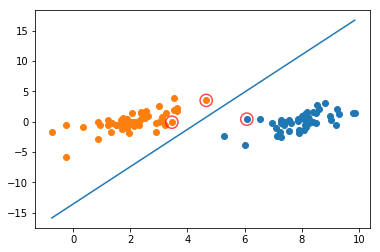

In [71]:
def showClassifier(dataMat, labelMat, w, b):
    dataPlus = []
    dataMinus = []
    for i in range(len(dataMat)):
        if labelMat[i] == 1.0:
            dataPlus.append(dataMat[i])
        else:
            dataMinus.append(dataMat[i])
    dataPlusArr = np.array(dataPlus).transpose()
    dataMinusArr = np.array(dataMinus).transpose()
    plt.scatter(dataPlusArr[0], dataPlusArr[1])
    plt.scatter(dataMinusArr[0], dataMinusArr[1])
    # 绘制直线
    x1 = max(dataMat)[0]
    x2 = min(dataMat)[0]
    a1, a2 = w
    a1 = a1[0]
    a2 = a2[0]
    y1 = (-b - a1 * x1) / a2
    y2 = (-b - a1 * x2) / a2
    plt.plot([x1, x2], [y1, y2])
    
    # 标出支持向量
    for i , alpha in enumerate(alphas):
        if abs(alpha) > 0:
            x, y = dataMat[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidths=1.5, edgecolors='red')
    plt.show()

showClassifier(dataMat, labelMat, w, b)